# Process Cycling Data

This notebook takes raw .csv files from the cycle life testing and returns a bunch of output plots. We assume that the data file contains data from both the Diagnostic Test (HPPC, C/20, C/3 steps) in addition to the 1C/1C charge/discharge steps. This makes parsing more complicated. We'll manage.

In [1]:
import numpy as np
import pandas as pd
import glob
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
import re

## Configure plot settings

In [2]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Helvetica'],
                  'size': 18
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (10, 8)
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes', labelsize='medium', grid=True)
plt.rc('legend', fontsize='medium')

DPI = 150
VOLTAGE_LIMITS = (2.95, 4.25)
CAPACITY_LIMITS = (0, 3)

## Configure project file path settings

In [3]:
# Data from June 2020; cycling data
PROJECT_FOLDER = '2020-08-microformation-cycling/time-series/'

GROUP_LIST = ['Baseline HT', 'Baseline RT', 'MicroForm HT', 'MicroForm RT']
FORMATION_TYPE = ['Baseline', 'Baseline', 'MicroForm', 'MicroForm']
TEST_TEMPERATURE = ['HT', 'RT', 'HT', 'RT']
FILE_GROUP_REGEX_LIST = ['UM_Internal_0620_-_BL_Form_-_HT-_Cycling_Cell_[0-9]*.[0-9]*.csv',
                         'UM_Internal_0620_-_BL_Form_-_Cycling_Cell_[0-9]*.[0-9]*.csv',
                         'UM_Internal_0620_-_Micro_Form_-_HT-_Cycling_Cell_[0-9]*.[0-9]*.csv',
                         'UM_Internal_0620_-_Micro_Form_-_Cycling_Cell_[0-9]*.[0-9]*.csv']

STEP_INDEX_C3_CHARGE = 7
STEP_INDEX_C3_DISCHARGE = 10
STEP_INDEX_C20_CHARGE = 13
STEP_INDEX_C20_DISCHARGE = 16
STEP_INDEX_HPPC_CHARGE = 22
STEP_INDEX_HPPC_DISCHARGE = 24

DATA_PATH = 'data/'
OUTPUT_PATH = 'output/'


In [4]:
fpath_group_list = [sorted(glob.glob(f'{DATA_PATH}{PROJECT_FOLDER}{f}')) for f in FILE_GROUP_REGEX_LIST]

## Load resources

In [5]:
def process_hppc_pulses(df_raw_data):
    """ 
    Takes in raw data and returns a data structure holding processed HPPC pulse information
    
    Uses step indices to infer start and end of each pulse.

    Args:
      df_raw_data (Pandas DataFrame)

    Returns a tuple (cycle indices, results)
        cycle indices (list) refers to the HPPC cycles
        results (list) is a list of Pandas DataFrames. Each DataFrame holds the contents 
           of the HPPC test result for the given cycle index 
    """


    df_hppc = df_raw_data[df_raw_data['Step Index'] == STEP_INDEX_HPPC_DISCHARGE]
    hppc_cycle_indices = np.unique(df_hppc['Cycle Number'])

    all_results = list()

    # Loop through each diagnostic test
    for curr_cyc in hppc_cycle_indices:

        curr_df = df_raw_data[df_raw_data['Cycle Number'] == curr_cyc]
        
        # Process each pulse 
        pulse_list = []
        for idx, point in enumerate(curr_df['Step Index'].values):
            
            if idx == 0: 
                continue

            # Detect pulse start
            if point == STEP_INDEX_HPPC_DISCHARGE \
                and curr_df['Step Index'].iloc[idx-1] != STEP_INDEX_HPPC_DISCHARGE:

                capacity = curr_df['Charge Capacity (Ah)'].iloc[idx-1]
                voltage_0 = curr_df['Potential (V)'].iloc[idx-1]

                # Detect pulse end
                voltage_1 = voltage_0
                jdx = idx + 1
                while True:
                    jdx += 1
                    if curr_df['Step Index'].iloc[jdx] != STEP_INDEX_HPPC_DISCHARGE:
                        voltage_1 = curr_df['Potential (V)'].iloc[jdx-1]
                        break

                duration_in_seconds = curr_df['Test Time (s)'].iloc[jdx] - \
                                      curr_df['Test Time (s)'].iloc[idx]
                
                current = np.abs(np.mean(curr_df['Current (A)'].iloc[idx:jdx]))
                resistance = (voltage_0 - voltage_1)/current

                result = dict()
                result['capacity'] = capacity
                result['voltage'] = voltage_0
                result['resistance'] = resistance
                result['current'] = current
                result['duration_in_seconds'] = duration_in_seconds

                pulse_list.append(result)

        result = pd.DataFrame(pulse_list)

        all_results.append(result)

    return (hppc_cycle_indices, all_results)

In [6]:
# Create a dictionary of values
#
# - key: group (e.g. 'Baseline HT')
#   - key: cellid 
#     - values

data = dict()

for group_name, file_list in zip(GROUP_LIST, fpath_group_list):

    curr_data = dict()
    for file_path in file_list:

        print(f'Loading raw data from {file_path}...')
        
        # Get raw data
        df_raw_data = pd.read_csv(file_path)
        # Do a bit of post-processing
        df_raw_data['Timestamp'] = pd.to_datetime(df_raw_data['Timestamp'], unit='ms')
        df_raw_data['Cycle Number'] += 1

        # Get cellid
        cellid = re.findall('\_[0-9]*.\.', file_path)
        cellid = int(cellid[0][1:-1])
        
        # Get cycle-by-cycle data, derived from raw data DataFrame
        df_cycle = df_raw_data \
                   .groupby('Cycle Number', as_index=False) \
                   .agg({
                       'Charge Capacity (Ah)': max, 
                       'Discharge Capacity (Ah)': max,
                       'Timestamp': min
                       })

        # Define coulombic efficiency cycle by cycle
        df_cycle['Coulombic Efficiency (%)'] = df_cycle['Discharge Capacity (Ah)']/df_cycle['Charge Capacity (Ah)']*100
        # Drop cycles with 0 charge capacity
        df_cycle = df_cycle[df_cycle['Charge Capacity (Ah)'] != 0]

        ## Get the features, cycle by cycle; derived from raw data DataFrame
        features_by_cycle_dict = dict()
        for n in df_raw_data['Cycle Number'].unique().tolist():
            iloc = df_raw_data['Cycle Number'] == n
            if max(df_raw_data['Charge Capacity (Ah)'][iloc]) == 0:
                continue
            features_dict = dict()
            features_dict['n'] = n
            features_dict['Q'] = df_raw_data['Charge Capacity (Ah)'][iloc]
            features_dict['V'] = df_raw_data['Potential (V)'][iloc]
            features_dict['dQdV'] = df_raw_data['dQ/dV (Ah/V)'][iloc]
            features_dict['Qd'] = df_raw_data['Discharge Capacity (Ah)'][iloc]
            features_by_cycle_dict[n] = features_dict

        # Package the data
        features = dict()
        features['raw'] = df_raw_data
        features['cycle'] = df_cycle
        features['features'] = features_dict
        features['hppc'] = process_hppc_pulses(df_raw_data)

        # Assignment into dict value
        curr_data[cellid] = features

    data[group_name] = curr_data

print('Done')


Loading raw data from data/2020-08-microformation-cycling/time-series/UM_Internal_0620_-_BL_Form_-_HT-_Cycling_Cell_1.022.csv...
Loading raw data from data/2020-08-microformation-cycling/time-series/UM_Internal_0620_-_BL_Form_-_HT-_Cycling_Cell_10.031.csv...
Loading raw data from data/2020-08-microformation-cycling/time-series/UM_Internal_0620_-_BL_Form_-_HT-_Cycling_Cell_2.023.csv...
Loading raw data from data/2020-08-microformation-cycling/time-series/UM_Internal_0620_-_BL_Form_-_HT-_Cycling_Cell_3.024.csv...
Loading raw data from data/2020-08-microformation-cycling/time-series/UM_Internal_0620_-_BL_Form_-_HT-_Cycling_Cell_4.025.csv...
Loading raw data from data/2020-08-microformation-cycling/time-series/UM_Internal_0620_-_BL_Form_-_HT-_Cycling_Cell_5.026.csv...
Loading raw data from data/2020-08-microformation-cycling/time-series/UM_Internal_0620_-_BL_Form_-_HT-_Cycling_Cell_6.027.csv...
Loading raw data from data/2020-08-microformation-cycling/time-series/UM_Internal_0620_-_BL_Form

## View available data

In [7]:
for group in data.keys():
    print(f'Group: {group}')
    print(f' -> cellids: {data[group].keys()}')
    print('')

Group: Baseline HT
 -> cellids: dict_keys([1, 10, 2, 3, 4, 5, 6, 7, 8, 9])

Group: Baseline RT
 -> cellids: dict_keys([11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

Group: MicroForm HT
 -> cellids: dict_keys([31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

Group: MicroForm RT
 -> cellids: dict_keys([21, 22, 23, 24, 25, 26, 27, 28, 29, 30])



## Visualize example data from Diagnostic Tests

In [26]:
GROUP = 'Baseline HT'
CELLID = 1

feature = data[GROUP][CELLID]
print(feature['raw'])

df_c20_charge = feature['raw'][feature['raw']['Step Index'] == STEP_INDEX_C20_CHARGE]
c20_test_cycle_indices = np.unique(df_c20_charge['Cycle Number'])

df_c3_charge = feature['raw'][feature['raw']['Step Index'] == STEP_INDEX_C3_CHARGE]
c3_test_cycle_indices = np.unique(df_c3_charge['Cycle Number'])

Datapoint Number  Test Time (s)  Cycle Number  Current (A)  \
0                      1           0.00             1     0.000000   
1                      2          10.00             1     0.000000   
2                      3          20.00             1     0.000000   
3                      4          30.00             1     0.000000   
4                      5          40.00             1     0.000000   
...                  ...            ...           ...          ...   
346262            346264     3817255.54           313     0.371557   
346263            346265     3817265.54           313     0.361944   
346264            346266     3817275.54           313     0.353246   
346265            346267     3817285.54           313     0.345922   
346266            346268     3817295.54           313     0.337987   

        Potential (V)  Step Index  Step Time (s)  Charge Capacity (Ah)  \
0            3.420157           1           0.00              0.000000   
1            3.4200

### Visualize example dV/dQ data

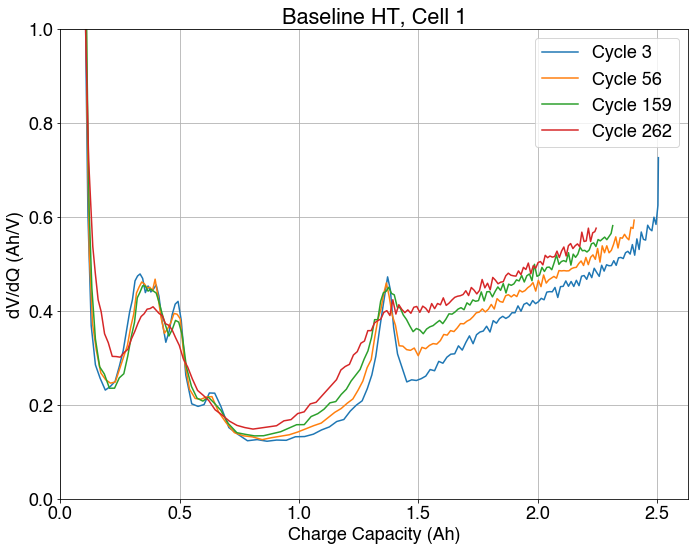

In [27]:
fig = plt.figure()
for curr_cyc in c20_test_cycle_indices:

    curr_df = df_c20_charge[df_c20_charge['Cycle Number'] == curr_cyc]
    curr_capacity = curr_df['Charge Capacity (Ah)']
    curr_voltage = curr_df['Potential (V)']
    curr_dvdq = 1/curr_df['dQ/dV (Ah/V)']
    
    X_VARIABLE = curr_capacity
    Y_VARIABLE = curr_dvdq

    # Export the results
    output = pd.DataFrame({'charge_capacity':curr_capacity,
                            'voltage': curr_voltage,
                            'dvdq': curr_dvdq}, index=None)
    output.to_csv(f'diagnostic_test_cell_{CELLID}_cyc_{curr_cyc}.csv')

    plt.plot(X_VARIABLE, Y_VARIABLE, label=f'Cycle {curr_cyc}')
    
plt.xlim(left=0)
plt.ylim((0,1))
plt.legend()
plt.xlabel('Charge Capacity (Ah)')
plt.ylabel('dV/dQ (Ah/V)')
plt.title(f'{GROUP}, Cell {CELLID}')
plt.savefig(f'{OUTPUT_PATH}dvdq_example.png', dpi=DPI)
plt.show()


### Visualize example voltage data

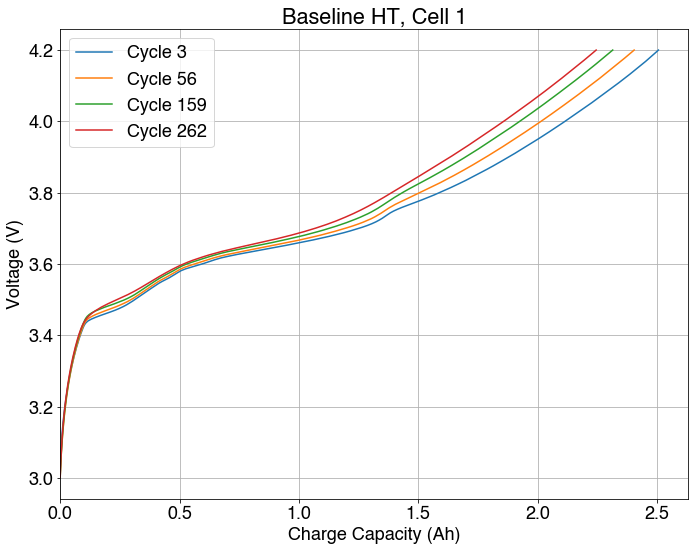

In [28]:
fig = plt.figure()
for curr_cyc in c20_test_cycle_indices:

    curr_df = df_c20_charge[df_c20_charge['Cycle Number'] == curr_cyc]
    curr_capacity = curr_df['Charge Capacity (Ah)']
    curr_voltage = curr_df['Potential (V)']
    curr_dvdq = 1/curr_df['dQ/dV (Ah/V)']
    
    X_VARIABLE = curr_capacity
    Y_VARIABLE = curr_voltage

    plt.plot(X_VARIABLE, Y_VARIABLE, label=f'Cycle {curr_cyc}')
    
plt.xlim(left=0)
plt.legend()
plt.xlabel('Charge Capacity (Ah)')
plt.ylabel('Voltage (V)')
plt.title(f'{GROUP}, Cell {CELLID}')
plt.savefig(f'{OUTPUT_PATH}voltage_curve_example.png', dpi=DPI)
plt.show()

### Visualize example resistance data

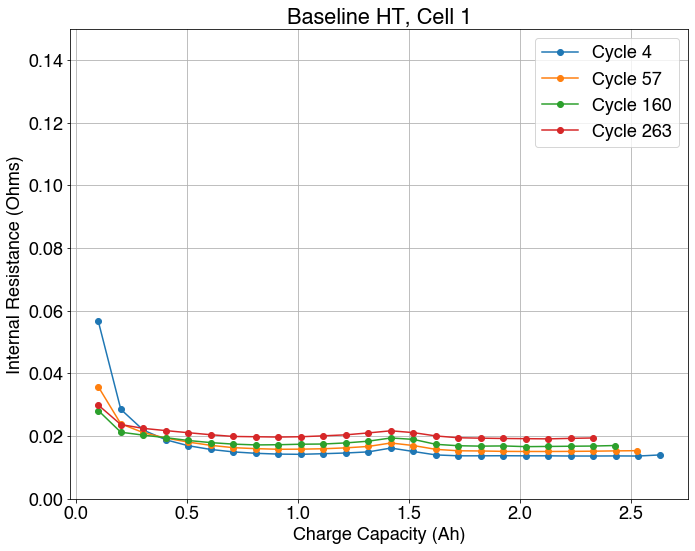

In [29]:

(hppc_cycle_indices, all_results) = feature['hppc']

fig = plt.figure()
for curr_cyc, result in zip(hppc_cycle_indices, all_results):

    X_VARIABLE = result['capacity']
    Y_VARIABLE = result['resistance']

    plt.plot(X_VARIABLE, Y_VARIABLE, marker='o',
                label=f'Cycle {curr_cyc}')
    
plt.legend()
plt.title(f'{GROUP}, Cell {CELLID}')
plt.xlabel('Charge Capacity (Ah)')
plt.ylabel('Internal Resistance (Ohms)')
plt.ylim((0, 0.15))
plt.savefig(f'{OUTPUT_PATH}internal_resistance_example.png', dpi=DPI)
plt.show()

## Plot all of the data

Baseline HT
Baseline RT
MicroForm HT
MicroForm RT


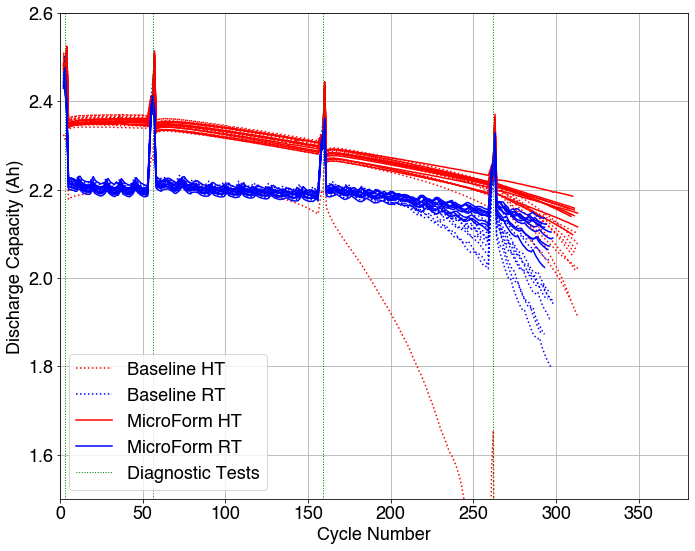

In [12]:
fig = plt.figure()
    
for group, temp, form_type in zip(data.keys(), TEST_TEMPERATURE, FORMATION_TYPE):
    
    print(group)
    has_plotted_once = False
    for cellid in data[group].keys():

        df = data[group][cellid]['cycle']

        label = '' if has_plotted_once else group
        color = 'r' if temp == 'HT' else 'b'
        linestyle = ':' if form_type == 'Baseline' else '-'

        plt.plot(df['Cycle Number'][0:-1], df['Discharge Capacity (Ah)'][0:-1],
                    linestyle=linestyle, color=color, label=label) 

        has_plotted_once = True

for idx, index in enumerate(c20_test_cycle_indices):
    label = 'Diagnostic Tests' if idx == 0 else ''
    plt.plot([index, index], [0, 5], color='g', linestyle=':', linewidth=1.0, label=label)

plt.legend()
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.ylim((1.5, 2.6))   
plt.xlim(left=0)
plt.savefig(f'{OUTPUT_PATH}cycle_test_result.png', dpi=DPI)

Baseline HT
Baseline RT
MicroForm HT
MicroForm RT


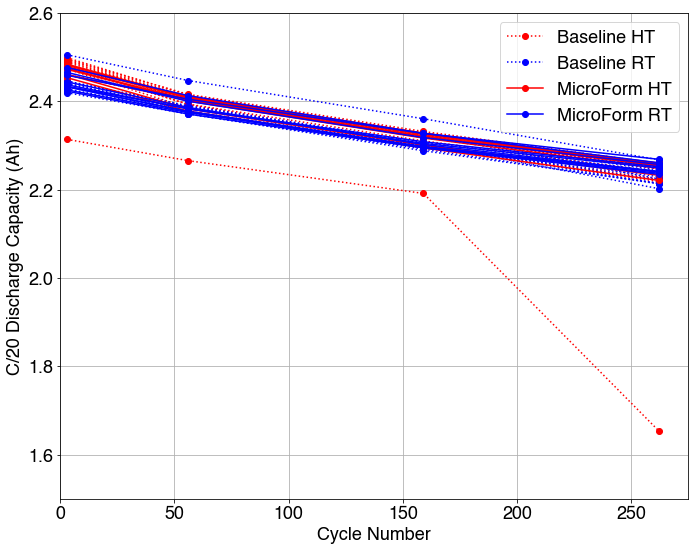

In [13]:
fig = plt.figure()
    
for group, temp, form_type in zip(data.keys(), TEST_TEMPERATURE, FORMATION_TYPE):
    
    print(group)
    has_plotted_once = False
    for cellid in data[group].keys():

        df = data[group][cellid]['cycle']

        df = df[df['Cycle Number'].isin(c20_test_cycle_indices)]
        label = '' if has_plotted_once else group
        color = 'r' if temp == 'HT' else 'b'
        linestyle = ':' if form_type == 'Baseline' else '-'

        plt.plot(df['Cycle Number'], df['Discharge Capacity (Ah)'],
                    linestyle=linestyle, color=color, 
                    marker='o', label=label) 

        has_plotted_once = True

plt.legend()
plt.xlabel('Cycle Number')
plt.ylabel('C/20 Discharge Capacity (Ah)')
plt.ylim((1.5, 2.6))   
plt.xlim(left=0)
plt.savefig(f'{OUTPUT_PATH}c_over_20_capacity_over_cycles.png', dpi=DPI)

Baseline HT
Baseline RT
MicroForm HT
MicroForm RT


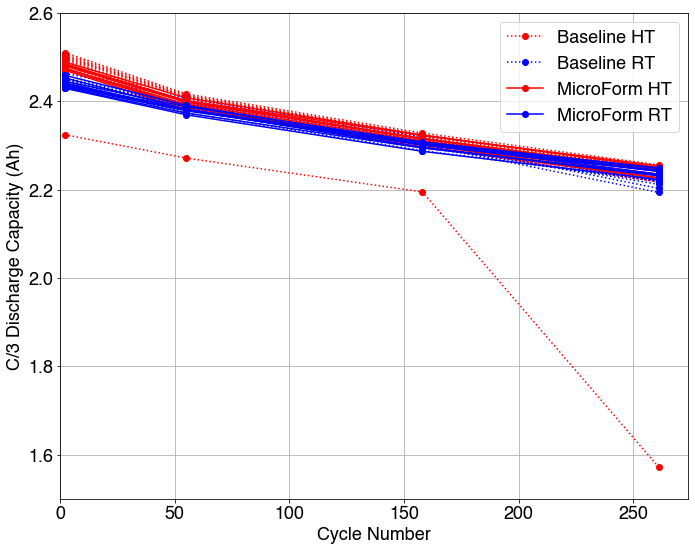

In [14]:
fig = plt.figure()
    
for group, temp, form_type in zip(data.keys(), TEST_TEMPERATURE, FORMATION_TYPE):
    
    print(group)
    has_plotted_once = False
    for cellid in data[group].keys():

        df = data[group][cellid]['cycle']

        df = df[df['Cycle Number'].isin(c3_test_cycle_indices)]
        label = '' if has_plotted_once else group
        color = 'r' if temp == 'HT' else 'b'
        linestyle = ':' if form_type == 'Baseline' else '-'

        plt.plot(df['Cycle Number'], df['Discharge Capacity (Ah)'],
                    linestyle=linestyle, color=color, 
                    marker='o', label=label) 

        has_plotted_once = True

plt.legend()
plt.xlabel('Cycle Number')
plt.ylabel('C/3 Discharge Capacity (Ah)')
plt.ylim((1.5, 2.6))   
plt.xlim(left=0)
plt.savefig(f'{OUTPUT_PATH}c_over_3_capacity_over_cycles.png', dpi=DPI)

Baseline HT
Baseline RT
MicroForm HT
MicroForm RT


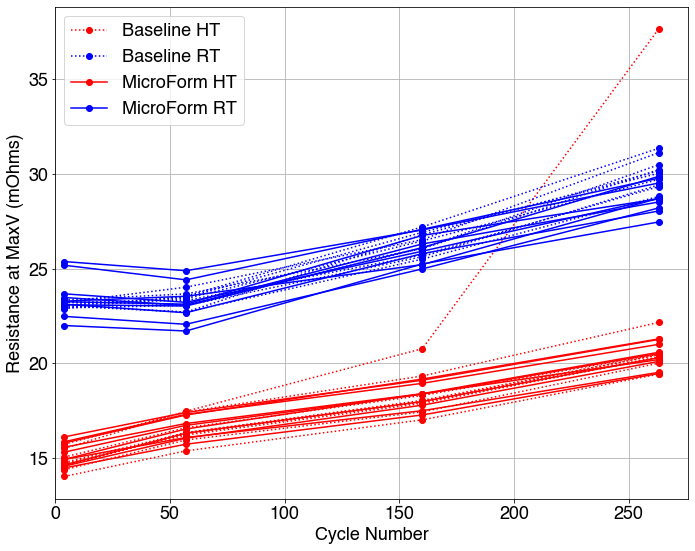

In [15]:
fig = plt.figure()
    
for group, temp, form_type in zip(data.keys(), TEST_TEMPERATURE, FORMATION_TYPE):
    
    print(group)
    has_plotted_once = False
    for cellid in data[group].keys():

        (hppc_cycle_indices, df_list) = data[group][cellid]['hppc']
 
        resistance = list()
        for idx, _ in enumerate(hppc_cycle_indices):
            resistance.append(df_list[idx]['resistance'].values[-1])
        resistance = np.array(resistance)

        label = '' if has_plotted_once else group
        color = 'r' if temp == 'HT' else 'b'
        linestyle = ':' if form_type == 'Baseline' else '-'

        plt.plot(hppc_cycle_indices, resistance*1000,
                    linestyle=linestyle, color=color, 
                    marker='o', label=label) 

        has_plotted_once = True

plt.legend()
plt.xlabel('Cycle Number')
plt.ylabel('Resistance at MaxV (mOhms)')
plt.xlim(left=0)
plt.savefig(f'{OUTPUT_PATH}max_v_resistances.png', dpi=DPI)